<a href="https://colab.research.google.com/github/mdzikrim/Hands-on_DL/blob/main/Chapter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt

# Load data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split validation set
X_valid, X_train = X_train_full[:10000], X_train_full[10000:]
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]

# Reshape
X_train = X_train.reshape(-1, 28*28)
X_valid = X_valid.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
def build_model():
    model = keras.models.Sequential([
        layers.Input(shape=(28*28,)),
        layers.Dense(300, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])
    return model

model = build_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

# Learning Rate Finder callback
class ExponentialLearningRate(callbacks.Callback):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.rates = []
        self.losses = []
        self.best_loss = float("inf")

    def on_batch_end(self, batch, logs=None):
        loss = logs["loss"]
        # Access and append the current learning rate as a float
        self.rates.append(float(self.model.optimizer.learning_rate.numpy()))
        self.losses.append(loss)
        if loss < self.best_loss:
            self.best_loss = loss
        if loss > 4 * self.best_loss:
            self.model.stop_training = True
        # Update the learning rate
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate * self.factor)

391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1541 - loss: 667.2129


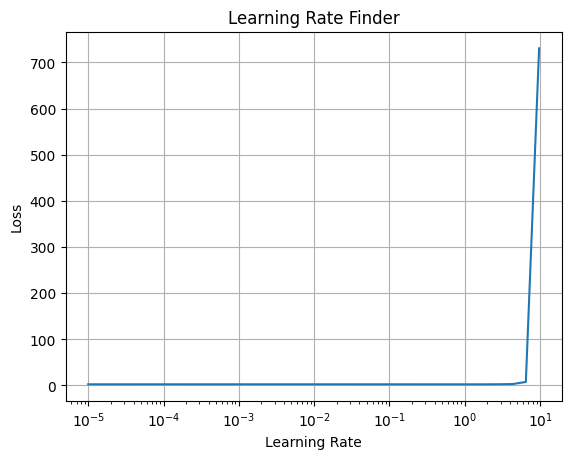

In [5]:
tf.keras.backend.clear_session()
model = build_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-5), metrics=["accuracy"])

lr_finder = ExponentialLearningRate()
history = model.fit(X_train, y_train, epochs=1, batch_size=128, callbacks=[lr_finder])

# Plot curve
plt.plot(lr_finder.rates, lr_finder.losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(True)
plt.title("Learning Rate Finder")
plt.show()


In [6]:
# Final training with best LR
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.1),
              metrics=["accuracy"])

early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),
                    callbacks=[early_stop])


Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8564 - loss: 0.4793 - val_accuracy: 0.9521 - val_loss: 0.1526
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9619 - loss: 0.1259 - val_accuracy: 0.9691 - val_loss: 0.1026
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9769 - loss: 0.0741 - val_accuracy: 0.9739 - val_loss: 0.0877
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9846 - loss: 0.0510 - val_accuracy: 0.9719 - val_loss: 0.0929
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9879 - loss: 0.0381 - val_accuracy: 0.9779 - val_loss: 0.0768
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9911 - loss: 0.0306 - val_accuracy: 0.9745 - val_loss: 0.0951
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9932 - loss: 0.0223 - val_accuracy: 0.9773 - val_loss: 0.0835
Epoch 8/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9960 - loss: 0.0146

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9772 - loss: 0.0813
Test accuracy: 0.9811


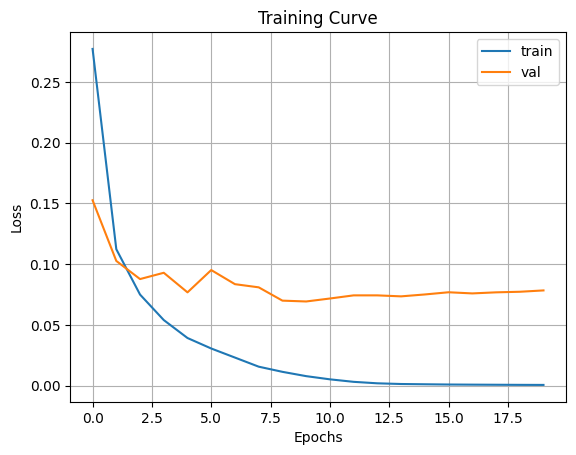

In [7]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Plot learning curves
pd = history.history
plt.plot(pd["loss"], label="train")
plt.plot(pd["val_loss"], label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Curve")
plt.grid(True)
plt.show()
